In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy, BatchNorm
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [6]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST(split=:train)[:]
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder , save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    decoder = Chain(
        Dense(20, 500, relu, bias = false),
        Dense(500,500, sigmoid, bias = false),
        Dense(500, 784, sigmoid, bias = false)
    )
    return encoder_μ, encoder_logvar, decoder
end



create_vae (generic function with 1 method)

In [7]:
function vae_loss(encoder_μ, encoder_logvar, decoder, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample


    x̂ = decoder(z)
    # x̂ = sigmoid(W3*relu(W2*relu(W1*z)))

    loss_α(F,A) = maximum(sqrt.(sum((F*A).*(F*A), dims = 2))) + 100*norm(A'*A - I(500),2)^2

    α = loss_α(F, Flux.params(decoder)[3])


    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(binarycrossentropy.(x̂, x)) 
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, decoder))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg + 10000 * α 
end

function train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # x_batch[x_batch .> .8] .= .8; x_batch[x_batch .< .2]  .= .2

            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [8]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 20
save_dir = "test/trained_GNN/MNIST_sigmoid_inco"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, decoder = create_vae()
train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, ADAM(η), save_dir)



In [161]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST(split=:test)[:]
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample


    # W1 = Flux.params(decoder)[1]
    # b1 = Flux.params(decoder)[3]

    # W2 = Flux.params(decoder)[5]
    # b2 = Flux.params(decoder)[7]

    # W3 = Flux.params(decoder)[9]
    # b3 = Flux.params(decoder)[11]

    # G = Chain(
    #     Dense( W1, b1, relu),
    #     Dense(W2, b2, relu),
    #     Dense(W3, b3, sigmoid)
    # )

    # x̂ = G(z)

    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function visualise()
    # Define some parameters
    batch_size = 1
    shuffle = true
    num_images = 1
    epoch_to_load = 20
    # Load the model and test set loader
    dir = "test/trained_GNN/MNIST_sigmoid_inco"
    encoder_μ, encoder_logvar, decoder = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
        print(size(x_batch))
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [162]:
visualise()

Loading model...Done


(784, 1)

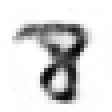

In [157]:
load("test/trained_GNN/MNIST_sigmoid_inco/reconstruction-1.png")

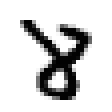

In [158]:
load("test/trained_GNN/MNIST_sigmoid_inco/test-image-1.png")

All function imported
Loading model...Done

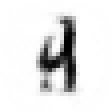

In [182]:
using NBInclude
@nbinclude("src/functions.ipynb")
epoch_to_load =20
# Load the model and test set loader
dir = "test/trained_GNN/MNIST_sigmoid_inco"
encoder_μ, encoder_logvar, decoder = load_model_identity(dir, epoch_to_load);


batch_size = 64; shuffle = true
dataloader = get_test_loader(batch_size, shuffle)
(x_batch, y_batch) = first(dataloader)

x = reshape(x_batch[:,1], 784,1)

μ = encoder_μ(x)
logvar = encoder_logvar(x)
# Apply reparameterisation trick to sample latent
z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)







In [102]:
Flux.params(decoder)[9]


784×500 Matrix{Float32}:
 -4.79074f-17  -3.18764f-18   1.15231f-18  …  -2.15314f-17  -8.35454f-18
  1.93924f-13  -1.31831f-13  -1.1671f-14       1.88386f-13   1.46927f-13
  1.72261f-16  -1.36608f-16   1.49686f-16     -4.72904f-17  -3.56617f-17
  3.86012f-18   4.15748f-18  -2.77459f-19     -2.14327f-18   4.23553f-19
 -2.68665f-20   2.06242f-19   1.72418f-19      4.55513f-20  -2.00354f-20
 -1.54281f-17   1.62059f-17   1.74588f-17  …  -3.20918f-18   7.46922f-18
  1.17776f-19   6.88555f-20   9.49247f-20      8.42116f-20   4.11666f-20
  3.10197f-20  -1.3666f-20    5.79683f-21      3.49628f-21  -1.36342f-21
  4.5031f-19    1.1528f-18    4.94344f-19     -2.22699f-19   6.82695f-19
  8.50925f-16   3.46845f-15   2.81665f-15     -2.53351f-15  -3.52455f-17
  ⋮                                        ⋱                
  0.00391903   -0.00289768    0.0208921    …   0.0409482     0.0231496
  0.0112742     0.0028156     0.0151134        0.0287003     0.0216682
  0.006198      0.00841768    0.0039179   

In [165]:
z =randn(20)

20-element Vector{Float64}:
 -0.03784081590906144
 -2.385492876685151
  0.5882618900938914
  1.2483459358584463
  2.95321293540162
 -2.0188647898656793
 -0.9545740562012338
  1.3929446623145727
 -0.6922157976937121
 -0.3536334064935157
  0.2552529042012072
  0.18518567013051632
  0.7516368735102402
  0.8347819242041975
  1.0010151657599082
  0.22768241383806123
  1.2008102346641967
 -1.132009244298939
 -0.568888712699821
  0.3140137594177993

In [136]:
Flux.params(decoder)[4]

500-element Vector{Float32}:
 0.49273956
 0.6395788
 0.88842183
 0.58276534
 0.6463669
 0.61070514
 1.1388037
 0.86091745
 0.5055823
 0.7362517
 ⋮
 0.6134886
 0.951209
 0.9815581
 0.5934283
 0.8466774
 0.9555311
 0.5895438
 0.865159
 1.1374868